In [1]:
# Cell 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# Install necessary packages
!pip install -q py7zr
!pip install -q pandas

import py7zr
import zipfile
import os

# Define file paths
sevenzip_filepath = '/kaggle/input/invasive-species-monitoring/train.7z'
zip_filepath = '/kaggle/input/invasive-species-monitoring/train_labels.csv.zip'

# Define extraction directories
sevenzip_extraction_dir = '/kaggle/working/train_data'
zip_extraction_dir = '/kaggle/working/train_labels'

# Create extraction directories
os.makedirs(sevenzip_extraction_dir, exist_ok=True)
os.makedirs(zip_extraction_dir, exist_ok=True)

# Extract .7z file
with py7zr.SevenZipFile(sevenzip_filepath, mode='r') as z:
    z.extractall(sevenzip_extraction_dir)

# Extract .zip file
with zipfile.ZipFile(zip_filepath, 'r') as z:
    z.extractall(zip_extraction_dir)

# Display the list of extracted files
print("Files extracted from .7z:")
print(os.listdir(sevenzip_extraction_dir))

print("\nFiles extracted from .zip:")
print(os.listdir(zip_extraction_dir))


Files extracted from .7z:
['train']

Files extracted from .zip:
['__MACOSX', 'train_labels.csv']


In [ ]:
import pandas as pd
import os

# Load your original CSV file with image labels
labels_df = pd.read_csv('/kaggle/working/train_labels/train_labels.csv')

# Convert all integer columns to strings
labels_df = labels_df.astype(str)

# Specify the directory containing your images
image_directory = '/kaggle/working/train_data/train'

# Create a new column 'path' with the full path to each image, adding ".jpg" to the end
labels_df['path'] = labels_df['name'].apply(lambda x: os.path.join(image_directory, x + ".jpg"))

# Save the new DataFrame to a new CSV file
new_csv_path = '/kaggle/working/new_labels.csv'
labels_df.to_csv(new_csv_path, index=False)


In [ ]:
import pandas as pd

# Load the new CSV file
new_labels_df = pd.read_csv('/kaggle/working/new_labels.csv')

# Print the first few rows of the DataFrame
print(new_labels_df.head())


In [ ]:
import pandas as pd

# Load the new CSV file
new_labels_df = pd.read_csv('/kaggle/working/new_labels.csv')

# Print the first few rows of the DataFrame
print(new_labels_df.head())


In [ ]:
import pandas as pd
import os

# Load your original CSV file with image labels
original_labels_df = pd.read_csv('/kaggle/working/new_labels.csv')

# Convert all integer columns to strings
original_labels_df = original_labels_df.astype(str)

# Specify the directory containing your images
image_directory = '/kaggle/working/train_data/train'


In [ ]:
# Load the new CSV file with the 'path' column
df = pd.read_csv('/kaggle/working/new_labels.csv')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam

# Perform cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Initialize InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Specify training parameters
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Lists to store training histories for each fold
all_histories = []

# Perform cross-validation training
for train_index, test_index in kf.split(df['path'], df['invasive']):
    train_data = df.iloc[train_index].copy()
    test_data = df.iloc[test_index].copy()

    train_data['invasive'] = train_data['invasive'].astype(str)
    test_data['invasive'] = test_data['invasive'].astype(str)

    train_data['file_exists'] = train_data['path'].apply(lambda x: os.path.exists(x))
    train_data = train_data[train_data['file_exists']]
    train_data.drop(columns=['file_exists'], inplace=True)

    test_data['file_exists'] = test_data['path'].apply(lambda x: os.path.exists(x))
    test_data = test_data[test_data['file_exists']]
    test_data.drop(columns=['file_exists'], inplace=True)

    if len(train_data) == 0 or len(test_data) == 0:
        print("No valid images found. Skipping this iteration.")
        continue

    train_generator = datagen.flow_from_dataframe(
        train_data,
        x_col='path',
        y_col='invasive',
        target_size=(299, 299),
        batch_size=32,
        subset='training',
        class_mode='binary'
    )

    val_generator = datagen.flow_from_dataframe(
        test_data,
        x_col='path',
        y_col='invasive',
        target_size=(299, 299),
        batch_size=32,
        subset='validation',
        class_mode='binary'
    )

    history = model.fit(
        train_generator,
        epochs=5,  # Update with the desired number of epochs
        validation_data=val_generator
    )

    all_histories.append(history)


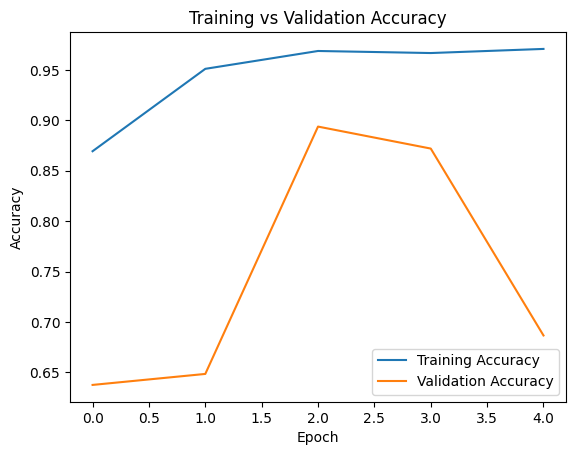

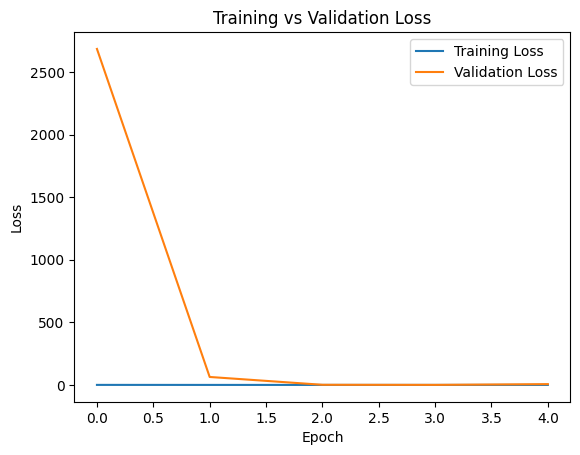

Found 459 validated image filenames belonging to 2 classes.
15/15 [==============================] - 36s 2s/step - loss: 0.4718 - accuracy: 0.8562
Test Accuracy: 85.62%
15/15 [==============================] - 38s 2s/step
Confusion Matrix:
[[ 83  87]
 [151 138]]
Overall Test Accuracy: 48.15%
Found 459 validated image filenames belonging to 2 classes.
15/15 [==============================] - 37s 2s/step - loss: 0.4353 - accuracy: 0.8649
Test Accuracy: 86.49%
15/15 [==============================] - 36s 2s/step
Confusion Matrix:
[[ 87  83]
 [145 144]]
Overall Test Accuracy: 50.33%
Found 459 validated image filenames belonging to 2 classes.
15/15 [==============================] - 36s 2s/step - loss: 0.4743 - accuracy: 0.8649
Test Accuracy: 86.49%
15/15 [==============================] - 36s 2s/step
Confusion Matrix:
[[ 82  87]
 [149 141]]
Overall Test Accuracy: 48.58%
Found 459 validated image filenames belonging to 2 classes.
15/15 [==============================] - 36s 2s/step - loss: 

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

# After the training loop
for history in all_histories:
    # Plot training vs validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()

    # Plot training vs validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

# Evaluate on the test set after the entire training process
for train_index, test_index in kf.split(df['path'], df['invasive']):
    # Extract test data for the entire dataset
    test_data = df.iloc[test_index].copy()
    test_data['invasive'] = test_data['invasive'].astype(str)
    
    # Filter out rows with missing image files
    test_data['file_exists'] = test_data['path'].apply(lambda x: os.path.exists(x))
    test_data = test_data[test_data['file_exists']]
    test_data.drop(columns=['file_exists'], inplace=True)

    if len(test_data) == 0:
        print("No valid images found. Skipping test evaluation.")
        continue

    # Create a new test generator
    test_generator = datagen.flow_from_dataframe(
        test_data,
        x_col='path',
        y_col='invasive',
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary'
    )

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)

    # Print test accuracy
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Get predictions on the test set
    y_pred = model.predict(test_generator)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(test_data['invasive'].astype(int), y_pred_binary)

    # Print confusion matrix
    print('Confusion Matrix:')
    print(cm)

    # Compute overall test accuracy
    overall_test_accuracy = accuracy_score(test_data['invasive'].astype(int), y_pred_binary)
    print(f'Overall Test Accuracy: {overall_test_accuracy * 100:.2f}%')
  